## 1. Setting up the environment

In [2]:
import numpy as np
import gym

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
# setting manual seed
torch.manual_seed(0)

from parallelEnv import parallelEnv

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# imports for rendering outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [3]:
# lets set up the cartpole environment
env = gym.make('Pendulum-v0')
env.seed(0)

# lets find about the action and state space
print("Action space: {} ... State space: {}".format(env.action_space,env.observation_space))

# lets print some info about action space range
action_high = env.action_space.high
action_low = env.action_space.low
print("action_high: {}\t action_low: {}".format(action_high,action_low))

Action space: Box(1,) ... State space: Box(3,)
action_high: [2.]	 action_low: [-2.]


In [4]:
# lets play a random episode

# reset env
state = env.reset()
step_count = 0
done = False

while (not done):
    # random action
    action = env.action_space.sample()
    # taking step in env
    next_state,reward,done,_ = env.step(action)
    
    # displaying progress
    print ("Step : {} ... state: {} ... action: {} ... reward: {} ... done: {}".format(step_count,
                                                                                       state[:4],action[:4],reward,done))
    
    # updating state and step count
    state = next_state
    step_count+=1

Step : 0 ... state: [-0.94223519 -0.33495202  0.93078187] ... action: [0.19525401] ... reward: -7.926888357788497 ... done: False
Step : 1 ... state: [-0.92977428 -0.36813012  0.70885596] ... action: [0.86075747] ... reward: -7.6939771290583225 ... done: False
Step : 2 ... state: [-0.91906665 -0.39410213  0.56187199] ... action: [0.4110535] ... reward: -7.52018189583656 ... done: False
Step : 3 ... state: [-0.91248103 -0.40911902  0.32795343] ... action: [0.17953274] ... reward: -7.409754858726039 ... done: False
Step : 4 ... state: [-0.91149561 -0.4113098   0.04804407] ... action: [-0.3053808] ... reward: -7.386228644680105 ... done: False
Step : 5 ... state: [-0.91768659 -0.39730506 -0.3062454 ] ... action: [0.58357644] ... reward: -7.47908659136635 ... done: False
Step : 6 ... state: [-0.92764336 -0.37346725 -0.51668773] ... action: [-0.24965115] ... reward: -7.63800526593766 ... done: False
Step : 7 ... state: [-0.94240996 -0.33445996 -0.83423584] ... action: [1.5670921] ... reward

## 2. Defining the policy

In [5]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cuda:0


In [6]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

class Policy(nn.Module):
    
    def __init__(self,state_size,action_size,action_high,action_low,hidden_size=32):
        super(Policy, self).__init__()
        
        # action range
        self.action_high = torch.tensor(action_high).to(device)
        self.action_low = torch.tensor(action_low).to(device)
        
        # fc layers for the policy network
        self.fc1 = nn.Linear(state_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3_action = nn.Linear(64,action_size)
        self.fc3_std = nn.Linear(64,action_size)
    
    def forward(self,state):
        net = F.relu(self.fc1(state))
        net = F.relu(self.fc2(net))
        action_mean = F.sigmoid(self.fc3_action(net))
        # rescale action mean
        action_mean_ = (self.action_high-self.action_low)*action_mean + self.action_low
        action_std = F.sigmoid(self.fc3_std(net))
        return action_mean_,action_std
    
    def act(self,state):
        # converting state from numpy array to pytorch tensor on the "device"
        state = torch.from_numpy(state).float().to(device)
        action_mean,action_std = self.forward(state)
        prob_dist = Normal(action_mean,action_std)
        action = prob_dist.sample()
        log_prob = prob_dist.log_prob(action)
        return action.cpu().numpy(),torch.sum(log_prob,dim=1)

## 3. Defining the RL agent

In [7]:
from collections import deque
from itertools import accumulate

def compute_future_rewards(rewards,gamma):
    future_rewards = np.zeros_like(rewards)
    discounted_rewards = np.zeros(rewards.shape[0])
    
    for time_step in range(future_rewards.shape[1]-1,-1,-1):
        future_rewards[:,time_step] = rewards[:,time_step] + gamma*discounted_rewards
        discounted_rewards = future_rewards[:,time_step]
    return future_rewards

class Agent:
    
    def __init__(self,env_name,learning_rate=1e-3):
        self.env = parallelEnv(env_name=env_name,n=25,seed=0)
        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.shape[0]
        self.policy = Policy(state_size=self.nS,hidden_size=128,action_size=self.nA,
                             action_low=action_low,action_high=action_high).to(device)
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=learning_rate)
        
    def train(self,max_opt_steps=1000,num_trajectories=25,horizon=1000,gamma=.99,PRINT_EVERY=100):
        # store eps scores
        scores = []
        scores_window = deque(maxlen=100)
        
        for opt_step in range(1,max_opt_steps+1):
            rewards = np.zeros([num_trajectories,horizon])
            log_probs = torch.zeros([num_trajectories,horizon])
            
            # reset state
            state = self.env.reset()

            # play an episode
            for t in range(horizon): 
                action,log_prob = self.policy.act(state)
                next_state,reward,done,_ = self.env.step(action)

                # update state
                state = next_state
                log_probs[:,t] = log_prob
                rewards[:,t] = reward

                # break if done
                if np.any(done):
                    break
            
            # compute advantage estimate to reduce variance
            future_rewards = compute_future_rewards(rewards,gamma)
            b = future_rewards.mean(axis=0)
            A = (future_rewards - b)/future_rewards.std(axis=0)
            A = torch.from_numpy(A).double().to(device)
            
            log_probs = log_probs.double().to(device)
            # compute loss and applying gradient
            loss = torch.sum(-log_probs*A)/(num_trajectories*horizon)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            trajectory_total_rewards = rewards.sum(axis=1)
            # update scores and score_window
            scores.append(np.mean(trajectory_total_rewards))
            scores_window.append(np.mean(trajectory_total_rewards))
            
            #printing progress
            if opt_step % PRINT_EVERY == 0:
                print ("Episode: {} ... Avg reward: {:.2f}".format(opt_step,np.mean(scores_window)))
                # save the policy
                torch.save(agent.policy, 'REINFORCE-Pendulum.policy')
            
            if np.mean(scores_window)>= -250.0:
                print ("Environment solved in {} optimization steps! ... Avg reward : {:.2f}".format(opt_step-100,
                                                                                          np.mean(scores_window)))
                # save the policy
                torch.save(agent.policy, 'REINFORCE-Pendulum.policy')
                break
                
        return scores

## 4. Training the agent!

In [8]:
# lets define and train our agent
agent = Agent(env_name='Pendulum-v0',learning_rate=1e-4)

In [9]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.99,PRINT_EVERY=100)

/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 100 ... Avg reward: -1188.27


/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 200 ... Avg reward: -1106.41
Episode: 300 ... Avg reward: -1075.48
Episode: 400 ... Avg reward: -1036.36
Episode: 500 ... Avg reward: -1014.07
Episode: 600 ... Avg reward: -986.11
Episode: 700 ... Avg reward: -950.85
Episode: 800 ... Avg reward: -918.07
Episode: 900 ... Avg reward: -901.74
Episode: 1000 ... Avg reward: -872.76
Episode: 1100 ... Avg reward: -853.23
Episode: 1200 ... Avg reward: -841.64
Episode: 1300 ... Avg reward: -819.06
Episode: 1400 ... Avg reward: -800.32
Episode: 1500 ... Avg reward: -776.46
Episode: 1600 ... Avg reward: -763.23
Episode: 1700 ... Avg reward: -751.30
Episode: 1800 ... Avg reward: -740.87
Episode: 1900 ... Avg reward: -726.77
Episode: 2000 ... Avg reward: -713.71
Episode: 2100 ... Avg reward: -698.07
Episode: 2200 ... Avg reward: -691.68
Episode: 2300 ... Avg reward: -687.77
Episode: 2400 ... Avg reward: -671.88
Episode: 2500 ... Avg reward: -674.27
Episode: 2700 ... Avg reward: -668.01
Episode: 2800 ... Avg reward: -648.97
Episode: 2900 ..

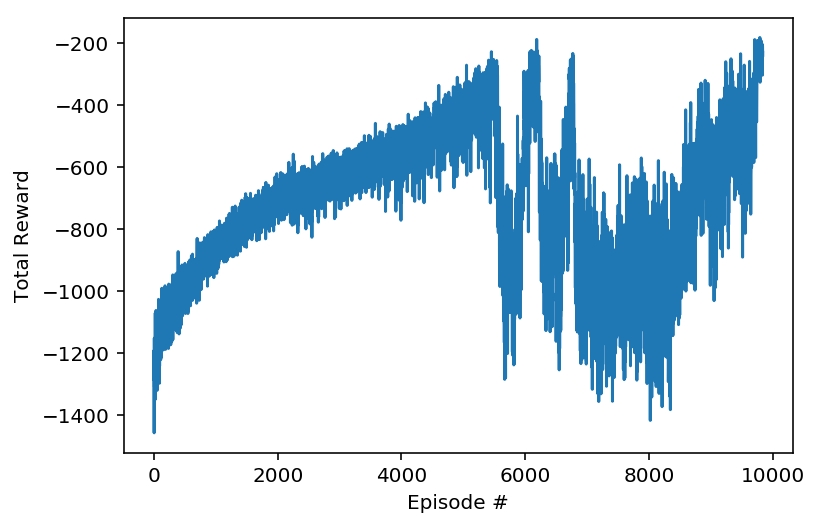

In [10]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

## 5. Watch the smart agent!

In [ ]:
# uncomment this cell to load the trained policy for Pendulum-v0
# load policy
policy =  torch.load('REINFORCE-Pendulum.policy',map_location='cpu')
agent = Agent(env_name='Pendulum-v0')
agent.policy = policy

In [ ]:
# function to animate a list of frames
def animate_frames(frames):
    plt.figure(dpi = 72)
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    display(display_animation(fanim, default_mode='once'))

In [ ]:
frames = []
total_reward = 0
state = env.reset()
for t in range(2000):
    action, _ = agent.policy.act(state[np.newaxis,:])
    frames.append(env.render(mode='rgb_array')) 
    next_state, reward, done, _ = env.step(action[0])
    state=next_state
    total_reward+= reward
    if done:
        break

print ("Total reward:",total_reward)
env.close()
animate_frames(frames)